In [2]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pyvirtualdisplay import Display

import tensorflow.compat.v1 as tf
from collections import deque
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input , BatchNormalization, Concatenate, LayerNormalization, LSTM,Reshape, Softmax,LeakyReLU,ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import tensorflow.keras.backend as K

import random
import tqdm
import pandas as pd

tf.disable_eager_execution()
import math
import time
from tf_agents.utils import  value_ops
import copy

In [3]:
tf.debugging.set_log_device_placement(True)


In [4]:
tf.reset_default_graph()

seed =0
tf.set_random_seed(seed)
np.random.seed(seed)

In [5]:
env = gym.make("HalfCheetah-v2")
state = env.reset()
obs_shape = env.observation_space.shape
n_actions = env.action_space
state = env.step(env.action_space.sample())
print("obs_shape",state)
print("n_actions",n_actions)
print([env.action_space.sample() for _ in range(5)])

obs_shape (array([  0.05543297,   0.12599613,   0.1752871 ,  -0.38036091,
        -0.042868  ,  -0.0527285 ,  -0.15370471,   0.10454714,
         0.27597373,  -0.12297586,   0.77742027,   3.79906048,
       -10.08636283,  -0.93250748,  -0.35378711,  -1.2951914 ,
         3.82976799]), 0.14518304613093233, False, {'reward_run': 0.28194151666621065, 'reward_ctrl': -0.13675847053527831})
n_actions Box(-1.0, 1.0, (6,), float32)
[array([-0.7506689 ,  0.24693465, -0.4865035 ,  0.00996476, -0.43499127,
        0.72638583], dtype=float32), array([-0.05162289, -0.8543323 , -0.31368375, -0.73999566,  0.5768543 ,
        0.597896  ], dtype=float32), array([-0.6169935 ,  0.3499701 , -0.50260127, -0.8266617 , -0.03412164,
       -0.09917451], dtype=float32), array([-0.4196122 ,  0.15226158, -0.98998815, -0.22545636,  0.02872533,
       -0.46008793], dtype=float32), array([-0.89847815, -0.30333567,  0.054662  ,  0.0880316 , -0.40520987,
        0.8372884 ], dtype=float32)]


In [7]:
## https://stackoverflow.com/questions/56226133/soft-actor-critic-with-discrete-action-space
#https://github.com/kengz/SLM-Lab/blob/master/slm_lab/agent/algorithm/sac.py
#https://github.com/shakti365/soft-actor-critic/blob/master/src/sac.py


6


In [6]:
action_space = env.action_space

def value_network(x):
    x = tf.layers.dense(x, units=256, activation=tf.nn.relu)
    x = tf.layers.dense(x, units=256, activation=tf.nn.relu)
    return tf.layers.dense(x, units=1, activation="linear")

def get_vars(scope):
    return [x for x in tf.global_variables() if scope in x.name]

def policy(x):
    act_dim = action_space.shape[0]
    x = tf.layers.dense(x, units=256, activation=tf.nn.relu)
    net = tf.layers.dense(x, units=256, activation=tf.nn.relu)
    mu = tf.layers.dense(net, act_dim, activation="linear")
    log_std = tf.layers.dense(net, act_dim, activation="linear")
    log_std = tf.clip_by_value(log_std, -20, 2)

    std = tf.exp(log_std)
    pi = mu + tf.random_normal(tf.shape(mu)) * std
    
    #Gaussian**********
    pre_sum = -0.5 * (((pi-mu)/(tf.exp(log_std)+1e-8))**2 + 2*log_std + np.log(2*np.pi))
    logp_pi = tf.reduce_sum(pre_sum, axis=1)
    #Squashing Function**********
    logp_pi -= tf.reduce_sum(2*(np.log(2) - pi - tf.nn.softplus(-2*pi)), axis=1)
    # Squash those unbounded actions!
    mu = tf.tanh(mu)
    pi = tf.tanh(pi)
    #***********************************
    
    action_scale = action_space.high[0]
    mu *= action_scale
    pi *= action_scale
    
    return mu, pi, logp_pi,std

def Actor_Critic(obs, act):
    # policy
    with tf.variable_scope('pi'):
        mu, pi, logp_pi,std = policy(obs)

    # vfs
    value_NN = lambda x : tf.squeeze(value_network(x), axis=1)
    with tf.variable_scope('q1'):
        q1 = value_NN(tf.concat([obs,act], axis=-1))
    with tf.variable_scope('q2'):
        q2 = value_NN(tf.concat([obs,act], axis=-1))
    return pi,logp_pi,mu,std,q1,q2

In [7]:
class HalfCheetah:
    def __init__(self, sess,env):
        self.sess =sess
        self.filepath = "D:\\Artificial_Intelligence\\RL\\Mujoco\\HCheetah\\Rewards.txt"
        self.memoryPathFile = "D:\\Artificial_Intelligence\\RL\\Mujoco\\HCheetah\\Memory.txt"
        self.batch_size = 100
        self.memory = deque(maxlen= 1000000)
        self.max_ep_len = 1000
        self.steps_per_epoch=4000
        self.epochs=100
        self.start_steps = 10000
        self.update_every=50
        self.update_after=1000
        self.total_steps = self.steps_per_epoch * self.epochs*8

        self.Training= self.total_steps
        self.learning_rate= 0.001
        self.gamma = 0.99
        self.polyak=0.995
        
        self.rewards_history = []
        self.alpha_history = []
        self.actor_history =[]
        self.critic1_history =[]
        self.critic2_history =[]
        self.soft_target_history = []
        self.target_history =[]
        self.alpha_target_history =[]
        self.alpha_exp_history =[]
        self.actionList =[]
        self.current_mu_history =[]
        self.current_sigma_history =[]
        self.logprobs_history =[]
        self.next_logprobs_history =[]
        self.alpha_log_history=[]
        self.current_q_history=[]
        self.current_q2_history=[]
        self.end_rewards=[]

        self.env = env
        self.obs_shape = self.env.observation_space.shape
        self.n_actions = self.env.action_space.shape[0]
        print("self.env.action_space.low[0]",self.env.action_space.low[0])
        print("self.env.action_space.high[0]",self.env.action_space.high[0])
        print("Observation shape:", self.obs_shape)
        print("Num actions:", self.n_actions)

        self.QNN1_optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.policyNN_optimizer =tf.train.AdamOptimizer(self.learning_rate)
        
        self.obs_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))    
        self.next_obs_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))
        self.actions_ph = tf.placeholder('float32', [None,] + list(self.env.action_space.shape))
        self.rewards_ph = tf.placeholder('float32', [None,])
        self.is_done_ph = tf.placeholder('float32', [None,])
  
        self.alpha = 0.2 #entropy temperature

        #*********************************************************************#
        
        self.actor_critic = Actor_Critic
        with tf.variable_scope("main"):
            pi,self.log_pi,self.mu,self.std, self.q1,self.q2  = self.actor_critic(self.obs_ph,self.actions_ph)
        
        with tf.variable_scope('main', reuse=True):
            _,_,_,_,self.q1_pi,self.q2_pi=  self.actor_critic(self.obs_ph,pi)

            pi_next,self.logp_pi_next,_,_,_,_ = self.actor_critic(self.next_obs_ph,self.actions_ph)
            
            
        with tf.variable_scope("target"):
            _,_,_,_,self.q1_targ,self.q2_targ  = self.actor_critic(self.next_obs_ph, pi_next) 
        
        min_q_pi = tf.minimum(self.q1_pi, self.q2_pi)
        min_q_targ = tf.minimum(self.q1_targ, self.q2_targ)
        
        self.Q_targets = tf.stop_gradient(self.rewards_ph + self.gamma*(1-self.is_done_ph)*(min_q_targ - self.alpha * self.logp_pi_next))
        
        self.actor_loss = tf.reduce_mean(self.alpha * self.log_pi - min_q_pi)
        self.critic_loss_1 = 0.5 * tf.reduce_mean((self.Q_targets - self.q1)**2)
        self.critic_loss_2 = 0.5 * tf.reduce_mean((self.Q_targets - self.q2)**2)
        self.critic_loss = self.critic_loss_1 + self.critic_loss_2
        
        
        print("self.obs_ph",self.obs_ph)
        print("logp_pi_next",self.logp_pi_next)
        print("min_q_targ",min_q_pi)
        print("min_q_targ",min_q_targ)
        print("pi_next",pi_next)
        print("Q_targets",self.Q_targets)
        self.train_actor = self.policyNN_optimizer.minimize(self.actor_loss, var_list=get_vars('main/pi'))
        
        with tf.control_dependencies([self.train_actor]):
            self.train_critic = self.QNN1_optimizer.minimize(self.critic_loss, var_list=get_vars('main/q'))
        
        with tf.control_dependencies([self.train_critic]):
            self.target_update = tf.group([tf.assign(v_targ,self. polyak*v_targ + (1-self.polyak)*v_main)
                                      for v_main, v_targ in zip(get_vars('main'), get_vars('target'))])

        self.target_init = tf.group([tf.assign(v_targ, v_main)
                                  for v_main, v_targ in zip(get_vars('main'), get_vars('target'))])
    
    def get_action(self,o):
        return self.sess.run(self.mu, feed_dict={self.obs_ph: o})[0]
    
    def evaluate(self, n_games=1):
        game_rewards = []
        for k in range(n_games):
            obs = self.env.reset()
            total_reward = 0
            ep_len  = 0
            done = False
            while not(done or (ep_len == self.max_ep_len)):
                action = self.get_action([obs])
                obs, reward, done, info = self.env.step(action)
                total_reward += reward
                ep_len += 1
            self.rewards_history.append(total_reward)

        return game_rewards

    def get_sample(self,reward_norm):
        batch = random.sample(self.memory, self.batch_size)
        s = np.array([each[0] for each in batch])
        a = np.array([each[1] for each in batch])
        s_ = np.array([each[2] for each in batch])
        r = np.array([each[3] for each in batch])
        
        dones = np.array([each[4] for each in batch])
        return s,a,r,s_,dones


    def train(self,it,reward_norm):

        s,a,r,s_,dones = self.get_sample(reward_norm)

        feed_dict = {
                self.obs_ph: s,
                self.actions_ph: a,
                self.next_obs_ph: s_,
                self.rewards_ph: r,
                self.is_done_ph: dones,
            }

        
        act,crit1,crit2,crit,log_pi,_,_,crit_targ,mu,sigma,q1,q2,_  = sess.run([self.actor_loss,self.critic_loss_1,self.critic_loss,
                                                                            self.critic_loss,self.log_pi,self.train_actor,self.train_critic,
                                                                            self.Q_targets,self.mu,self.std,self.q1,self.q2,self.target_update], feed_dict)

        
        self.actor_history.append(np.mean(act))
        self.critic1_history.append(np.mean(crit1))
        self.critic2_history.append(np.mean(crit2))
        self.logprobs_history.append(np.mean(log_pi))
        self.target_history.append(np.mean(crit_targ))
        self.current_mu_history.append(np.mean(mu))
        self.current_sigma_history.append(np.mean(sigma))
        self.current_q_history.append(np.mean(q1))
        self.current_q2_history.append(np.mean(q2))
        
        self.actionList.append(np.mean(a))
   

    def ewma(self,x, span=100):
        return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

    def plots(self):
        ipythondisplay.clear_output(wait=True)
        plt.figure(figsize=[35,13])
        plt.subplot(2,4,1)
        plt.plot(self.rewards_history, label='reward')
        plt.title("Session rewards"); plt.grid(); plt.legend()

        plt.subplot(2,4,2)
        plt.plot(self.actor_history, label='Actor Loss')
        plt.title("Policy Function"); plt.grid(); plt.legend()  
        
        plt.subplot(2,4,3)
        plt.plot(self.critic1_history, label='Critic Loss 1')
        plt.plot(self.critic2_history, label='Critic Loss 2')
        plt.title("Value function"); plt.grid(); plt.legend()   
    
        plt.subplot(2,4,4)
        plt.plot(self.current_q_history, label='Current Q1')
        plt.plot(self.current_q2_history, label='Current Q2')
        plt.plot(self.target_history, label='QNet Target - Critic Target ')
        plt.title("Current QValue vs Targets QValue"); plt.grid(); plt.legend()  

        plt.subplot(2,4,5)
        plt.plot(self.current_mu_history, label='Mu')
        plt.plot(self.current_sigma_history, label='Sigma')
        plt.title("Mean/Std"); plt.grid(); plt.legend()  
        
        plt.subplot(2,4,6)
        plt.plot(self.logprobs_history, label='logprobs history')
        plt.title("Log prob"); plt.grid(); plt.legend()  
        
        plt.subplot(2,4,7)
        plt.plot(self.actionList, label='Actions')
        plt.title("Actions"); plt.grid(); plt.legend()  
        
        plt.subplot(2,4,8)
        plt.plot(self.end_rewards, label='State Value')
        plt.title("State Value"); plt.grid(); plt.legend()
        plt.show()



In [8]:
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(graph= tf.get_default_graph(), config =config )

hCheetah = HalfCheetah(sess,gym.make("HalfCheetah-v2"))
env = gym.make("HalfCheetah-v2")

RESET=1

if (RESET == 1):
    # ************ RESET everything **************************
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

else:
    # ************ LOAD everything **************************
    ep_len=1000
    start = 1000
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('D:\\Artificial_Intelligence\\RL\\Mujoco\\HCheetah\\'))
    
    #Get Return
    f=open(hCheetah.filepath,'r')
    for line in f:
        hCheetah.rewards_history.append(float(line.split()[0]))
    f.close()
    hCheetah.plots()
    
    #Get memory
    f=open(hCheetah.memoryPathFile,'r')
    for line in f:
        hCheetah.memory.append([float(line.split()[0]),float(line.split()[1]),float(line.split()[2]),float(line.split()[3]),float(line.split()[4])])
    f.close()
    

    


f=open(hCheetah.filepath, "w")
f.write("")
f.close()
sess.run(hCheetah.target_init)


self.env.action_space.low[0] -1.0
self.env.action_space.high[0] 1.0
Observation shape: (17,)
Num actions: 6


c:\users\yanie\anaconda3\envs\py7\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
c:\users\yanie\anaconda3\envs\py7\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


self.obs_ph Tensor("Placeholder:0", shape=(None, 17), dtype=float32)
logp_pi_next Tensor("main_1/pi_1/sub_3:0", shape=(None,), dtype=float32)
min_q_targ Tensor("Minimum:0", shape=(None,), dtype=float32)
min_q_targ Tensor("Minimum_1:0", shape=(None,), dtype=float32)
pi_next Tensor("main_1/pi_1/mul_6:0", shape=(None, 6), dtype=float32)
Q_targets Tensor("StopGradient:0", shape=(None,), dtype=float32)


In [9]:
print(get_vars('main/pi'))

[<tf.Variable 'main/pi/dense/kernel:0' shape=(17, 256) dtype=float32>, <tf.Variable 'main/pi/dense/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'main/pi/dense_1/kernel:0' shape=(256, 256) dtype=float32>, <tf.Variable 'main/pi/dense_1/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'main/pi/dense_2/kernel:0' shape=(256, 6) dtype=float32>, <tf.Variable 'main/pi/dense_2/bias:0' shape=(6,) dtype=float32>, <tf.Variable 'main/pi/dense_3/kernel:0' shape=(256, 6) dtype=float32>, <tf.Variable 'main/pi/dense_3/bias:0' shape=(6,) dtype=float32>, <tf.Variable 'main/pi/dense/kernel/Adam:0' shape=(17, 256) dtype=float32>, <tf.Variable 'main/pi/dense/kernel/Adam_1:0' shape=(17, 256) dtype=float32>, <tf.Variable 'main/pi/dense/bias/Adam:0' shape=(256,) dtype=float32>, <tf.Variable 'main/pi/dense/bias/Adam_1:0' shape=(256,) dtype=float32>, <tf.Variable 'main/pi/dense_1/kernel/Adam:0' shape=(256, 256) dtype=float32>, <tf.Variable 'main/pi/dense_1/kernel/Adam_1:0' shape=(256, 256) dtype=float32>, 

In [10]:
print(get_vars('main'))

[<tf.Variable 'main/pi/dense/kernel:0' shape=(17, 256) dtype=float32>, <tf.Variable 'main/pi/dense/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'main/pi/dense_1/kernel:0' shape=(256, 256) dtype=float32>, <tf.Variable 'main/pi/dense_1/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'main/pi/dense_2/kernel:0' shape=(256, 6) dtype=float32>, <tf.Variable 'main/pi/dense_2/bias:0' shape=(6,) dtype=float32>, <tf.Variable 'main/pi/dense_3/kernel:0' shape=(256, 6) dtype=float32>, <tf.Variable 'main/pi/dense_3/bias:0' shape=(6,) dtype=float32>, <tf.Variable 'main/q1/dense/kernel:0' shape=(23, 256) dtype=float32>, <tf.Variable 'main/q1/dense/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'main/q1/dense_1/kernel:0' shape=(256, 256) dtype=float32>, <tf.Variable 'main/q1/dense_1/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'main/q1/dense_2/kernel:0' shape=(256, 1) dtype=float32>, <tf.Variable 'main/q1/dense_2/bias:0' shape=(1,) dtype=float32>, <tf.Variable 'main/q2/dense/kernel:0' sha

In [11]:
print(get_vars('target'))

[<tf.Variable 'target/pi/dense/kernel:0' shape=(17, 256) dtype=float32>, <tf.Variable 'target/pi/dense/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'target/pi/dense_1/kernel:0' shape=(256, 256) dtype=float32>, <tf.Variable 'target/pi/dense_1/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'target/pi/dense_2/kernel:0' shape=(256, 6) dtype=float32>, <tf.Variable 'target/pi/dense_2/bias:0' shape=(6,) dtype=float32>, <tf.Variable 'target/pi/dense_3/kernel:0' shape=(256, 6) dtype=float32>, <tf.Variable 'target/pi/dense_3/bias:0' shape=(6,) dtype=float32>, <tf.Variable 'target/q1/dense/kernel:0' shape=(23, 256) dtype=float32>, <tf.Variable 'target/q1/dense/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'target/q1/dense_1/kernel:0' shape=(256, 256) dtype=float32>, <tf.Variable 'target/q1/dense_1/bias:0' shape=(256,) dtype=float32>, <tf.Variable 'target/q1/dense_2/kernel:0' shape=(256, 1) dtype=float32>, <tf.Variable 'target/q1/dense_2/bias:0' shape=(1,) dtype=float32>, <tf.Variable 

In [12]:
obs= env.reset()

In [ ]:
ep_len=0
with tqdm.trange(0, hCheetah.Training) as t:
    for i in t:
        
        if i > hCheetah.start_steps:
            action = hCheetah.get_action([obs])
        else:
            action = env.action_space.sample()
            
        next_obs, reward, done, info = env.step(action)
        ep_len += 1
        done = False if ep_len==hCheetah.max_ep_len else done
        
        hCheetah.memory.append([obs,action,next_obs,reward,done])
        
        obs = next_obs
        
        if done or (ep_len == hCheetah.max_ep_len):
            obs= env.reset()
            ep_len= 0
            
        if i >= hCheetah.update_after and i % hCheetah.update_every == 0:
            for j in range(hCheetah.update_every):
                hCheetah.train(i,5)

        if len(hCheetah.rewards_history)> 100 :
            if np.mean(hCheetah.rewards_history[-100:]) >= 12000:
                print("Your agent reached the objetive")
                break
        
        if (i+1) % hCheetah.steps_per_epoch == 0:
            #env_aux.render()
            hCheetah.evaluate(n_games=10)
            
        if i % 500 == 0 :
            hCheetah.plots()
            print(" memory size = %.5f" % (len(hCheetah.memory)))

            
            


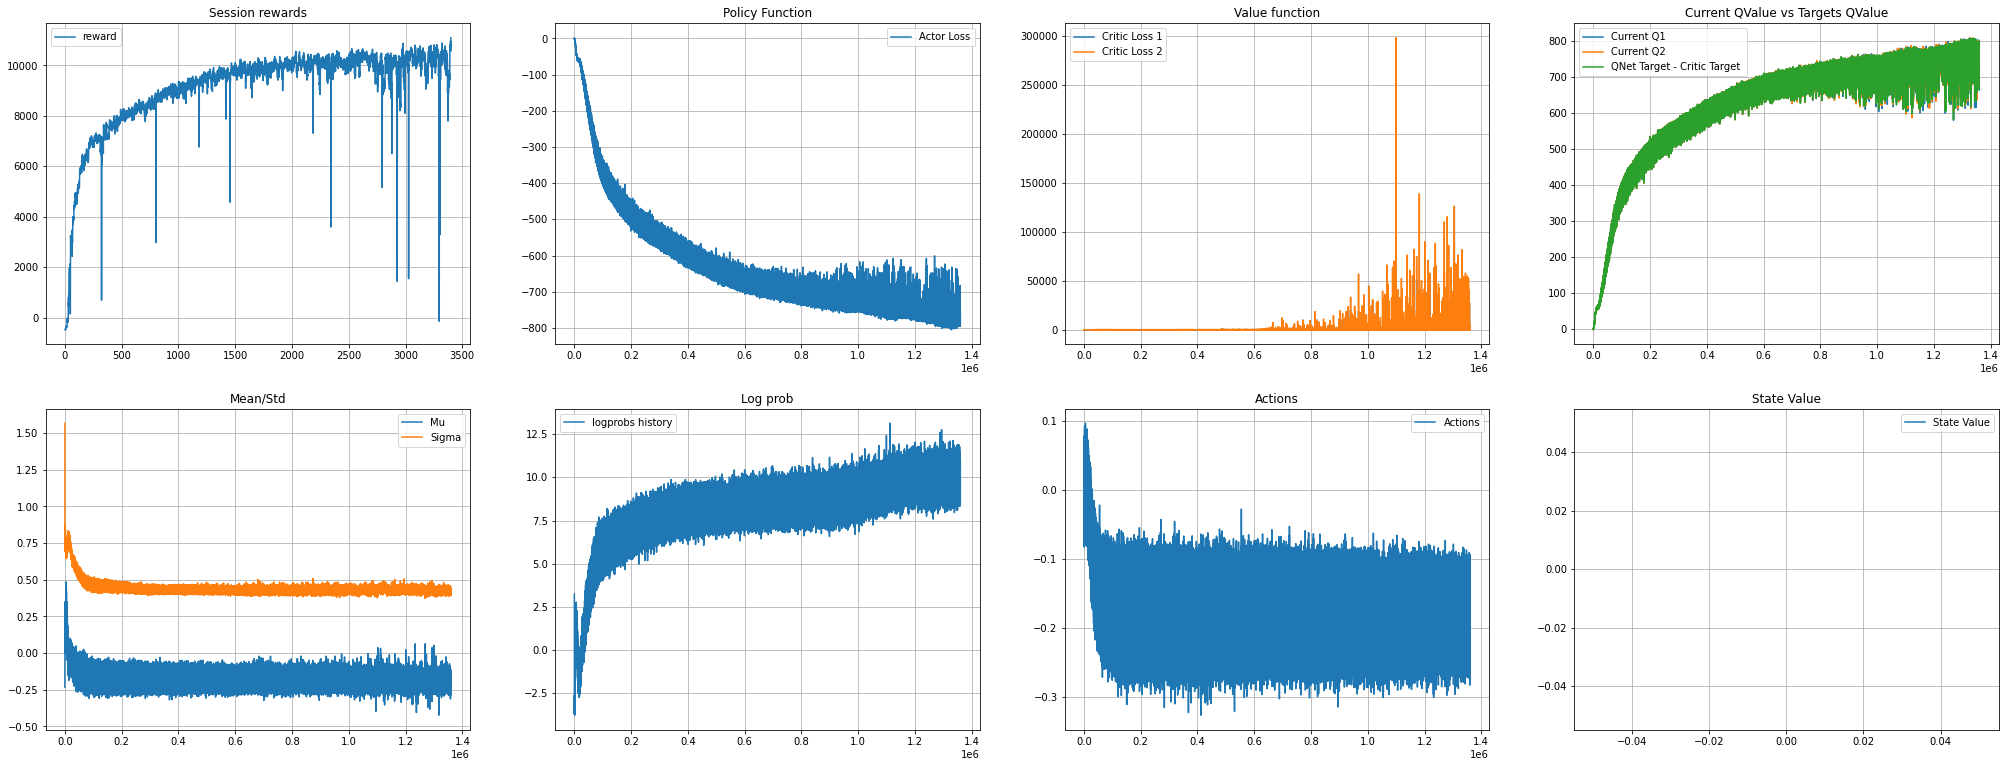

10023.4197569785


In [14]:
hCheetah.plots()
print(np.mean(hCheetah.rewards_history[-100:]))

In [15]:
saver.save(sess, "D:\\Artificial_Intelligence\\RL\\Mujoco\\HCheetah\\model.h5")

'D:\\Artificial_Intelligence\\RL\\Mujoco\\HCheetah\\model.h5'

In [16]:

with open(hCheetah.filepath, "w") as f:
    for i in range(len(hCheetah.rewards_history)):
        f.write("%f\n" % (hCheetah.rewards_history[i]))


# 

In [ ]:
obs= env.reset()
done = False
for i in range(10000):
    action = hCheetah.get_action([obs])
    obs, reward, done, _ = env.step(action)
    env.render()
    time.sleep(0.2)
env.close()